In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


In [2]:
import pandas as pd

train = pd.read_csv("/kaggle/input/heartbeat/mitbih_train.csv", header=None)
test = pd.read_csv("/kaggle/input/heartbeat/mitbih_test.csv", header=None)

print(train.shape, test.shape)
train.head()


(87554, 188) (21892, 188)


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


==> 
Each row = one heartbeat signal (length 187 samples).

Last column = label (heartbeat category).

In [3]:
train_labels = train[187]
print(train_labels.value_counts())


187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


==>  class imbalance (normal beats dominate, rare arrhythmias are fewer).

# Visualize Heartbeats

Try plotting multiple beats from different classes to compare.

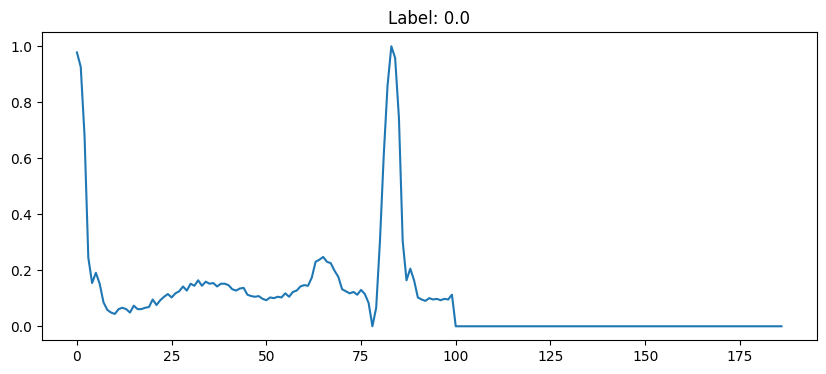

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(train.iloc[0,:187])
plt.title(f"Label: {train.iloc[0,187]}")
plt.show()


# Modeling 
* Preprocessing: Normalize signals (e.g., divide by max).
* ML Approach: Train a RandomForest or Logistic Regression on raw signals.
* Deep Learning: Use CNN/LSTM for time-series classification.


In [5]:
## remove this 
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import numpy as np

# Verify GPU is detected
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("Running on GPU")
else:
    print("Warning: Running on CPU. Enable GPU accelerator in Kaggle settings.")

2026-01-20 04:56:16.825919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768884976.998352      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768884977.050109      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768884977.486565      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768884977.486598      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768884977.486601      24 computation_placer.cc:177] computation placer alr

Num GPUs Available:  1
Running on GPU


* First Convolution 
 Padding='same' keeps the time dimension consistent
* Second Convolution 
* Adjust Shortcut (if dimensions change) 
    If the input shape doesn't match the output shape (due to stride or different filters),
* Add Skip Connection     

In [6]:
def residual_block(x, filters, kernel_size=5, stride=1):
    """
    Creates a residual block with two 1D convolution layers and a skip connection.
    """
    shortcut = x
    
    
    x = layers.Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)


    x = layers.Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    
    if x.shape[-1] != shortcut.shape[-1] or stride != 1:
        shortcut = layers.Conv1D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    
    return x

 * --- Initial Convolution ---
 * Standard conv layer to process raw input before entering ResBlocks
 * --- Stack Residual Blocks ---
 * We increase filters (32 -> 64 -> 128) as we go deeper to capture complex features
 * We use stride=2 periodically to downsample the time dimension (replacing MaxPool)
 * GlobalAveragePooling1D averages the entire time dimension into a single vector
 * This is much more efficient than Flatten() for 1D signals
 * Softmax for multi-class classification
 * Instantiate model

In [7]:
def build_1d_resnet(input_shape=(187, 1), num_classes=5):
    inputs = layers.Input(shape=input_shape)

    
    
    x = layers.Conv1D(32, 5, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    
    x = residual_block(x, 32, kernel_size=5, stride=1)
    x = residual_block(x, 32, kernel_size=5, stride=1)
    
    x = residual_block(x, 64, kernel_size=5, stride=2) # Downsample here
    x = residual_block(x, 64, kernel_size=5, stride=1)
    
    x = residual_block(x, 128, kernel_size=5, stride=2) # Downsample here
    x = residual_block(x, 128, kernel_size=5, stride=1)

    # --- Output Layers ---
   
    x = layers.GlobalAveragePooling1D()(x)
    
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="ECG_ResNet")
    return model


model = build_1d_resnet()
model.summary()

I0000 00:00:1768884990.440130      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "ECG_ResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 187, 32)   │        192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 187, 32)   │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 187, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 187, 32)   │      5,152 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 187, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 187, 32)   │      5,152 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 187, 32)   │          0 │ batch_normalizat… │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 187, 32)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 187, 32)   │      5,152 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 187, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 187, 32)   │      5,152 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 187, 32)   │          0 │ batch_normalizat… │
│                     │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 187, 32)   │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 395,525 (1.51 MB)

 Trainable params: 393,285 (1.50 MB)

 Non-trainable params: 2,240 (8.75 KB)

# load and preprocess data


1. Load the Datasets
Note: Kaggle file paths usually look like this. 
If this fails, check the "Input" sidebar on the right of your notebook for the exact path.
2. Convert to Numpy Arrays

In [8]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical


train_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)
test_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv', header=None)


train_data = train_df.values
test_data = test_df.values

X_train = train_data[:, :-1]
y_train = train_data[:, -1]

X_test = test_data[:, :-1]
y_test = test_data[:, -1]


X_train = X_train.reshape(X_train.shape[0], 187, 1)
X_test = X_test.reshape(X_test.shape[0], 187, 1)


y_train = y_train.astype(int)
y_test = y_test.astype(int)

print("Data Loaded Successfully!")
print(f"X_train shape: {X_train.shape}") # Should be (87554, 187, 1)
print(f"y_train shape: {y_train.shape}") # Should be (87554,)

Data Loaded Successfully!
X_train shape: (87554, 187, 1)
y_train shape: (87554,)


In [9]:

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', # Use 'categorical_crossentropy' if labels are one-hot encoded
    metrics=['accuracy']
)


my_callbacks = [
    # Stop training if validation loss doesn't improve for 5 epochs
    callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    
    # Reduce learning rate if training plateaus ==> converge to global minimum)
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# --- Training Configuration ---

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,             
    batch_size=128,        
    callbacks=my_callbacks
)

Epoch 1/20


I0000 00:00:1768885005.697538      67 service.cc:152] XLA service 0x7da244003c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768885005.697579      67 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768885007.278068      67 cuda_dnn.cc:529] Loaded cuDNN version 91002


 11/685 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8433 - loss: 0.6384

I0000 00:00:1768885012.551464      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


685/685 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.9464 - loss: 0.1943 - val_accuracy: 0.9464 - val_loss: 0.2261 - learning_rate: 0.0010
Epoch 2/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9746 - loss: 0.0906 - val_accuracy: 0.9563 - val_loss: 0.1844 - learning_rate: 0.0010
Epoch 3/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9802 - loss: 0.0684 - val_accuracy: 0.9781 - val_loss: 0.0796 - learning_rate: 0.0010
Epoch 4/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9835 - loss: 0.0551 - val_accuracy: 0.9722 - val_loss: 0.0890 - learning_rate: 0.0010
Epoch 5/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9853 - loss: 0.0498 - val_accuracy: 0.9655 - val_loss: 0.1193 - learning_rate: 0.0010
Epoch 6/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9861 - loss: 0.0462 - val_accuracy: 0.9809 - val_loss: 0.0826 - learning_rate: 0.0010
Epoch 7/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9917 - loss: 0.0270 - val

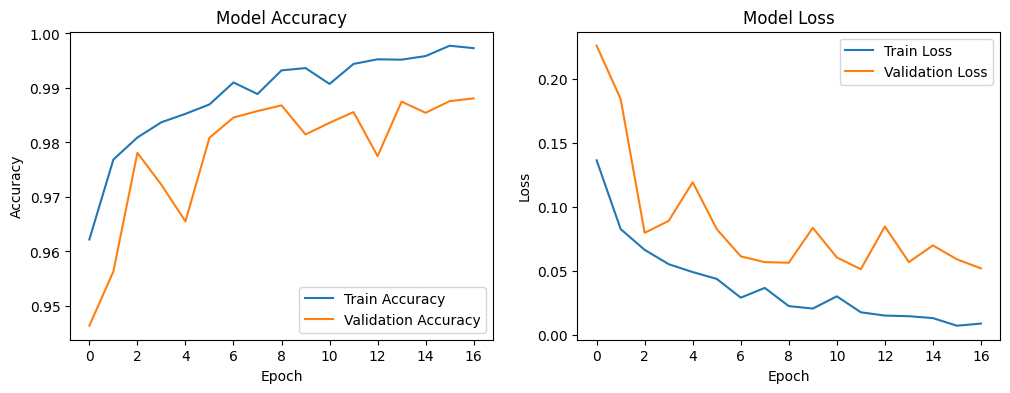

In [10]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
               precision    recall  f1-score   support

       Normal       0.99      0.99      0.99     18118
S-Ventricular       0.82      0.84      0.83       556
  Ventricular       0.97      0.97      0.97      1448
       Fusion       0.88      0.77      0.82       162
      Unknown       0.99      0.99      0.99      1608

     accuracy                           0.99     21892
    macro avg       0.93      0.91      0.92     21892
 weighted avg       0.99      0.99      0.99     21892



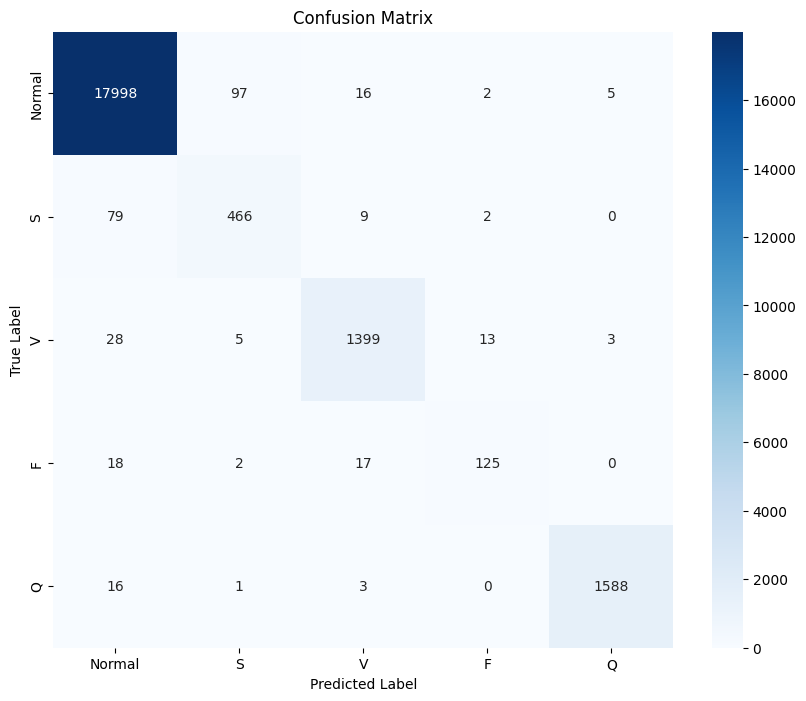

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


pred_probs = model.predict(X_test)
pred_classes = np.argmax(pred_probs, axis=1)


print(classification_report(y_test, pred_classes, 
                            target_names=['Normal', 'S-Ventricular', 'Ventricular', 'Fusion', 'Unknown']))


cm = confusion_matrix(y_test, pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'S', 'V', 'F', 'Q'],
            yticklabels=['Normal', 'S', 'V', 'F', 'Q'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [12]:
model.save('my_model1.keras') 

# compare with report

In [13]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import pandas as pd


y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


accuracy = accuracy_score(y_test, y_pred)
print(f"Your Overall Accuracy: {accuracy * 100:.2f}%")
print(f"Paper Benchmark (Kachuee et al.): 93.40%\n")


classes = ['N (Normal)', 'S (Supraventricular)', 'V (Ventricular)', 'F (Fusion)', 'Q (Unknown)']
report = classification_report(y_test, y_pred, target_names=classes, output_dict=True)


comparison_data = {
    'Class': classes,
    'Your Precision': [report[c]['precision'] for c in classes],
    'Your Recall': [report[c]['recall'] for c in classes],
    'Your F1-Score': [report[c]['f1-score'] for c in classes]
}

comp_df = pd.DataFrame(comparison_data)
print(comp_df.round(3))

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Your Overall Accuracy: 98.56%
Paper Benchmark (Kachuee et al.): 93.40%

                  Class  Your Precision  Your Recall  Your F1-Score
0            N (Normal)           0.992        0.993          0.993
1  S (Supraventricular)           0.816        0.838          0.827
2       V (Ventricular)           0.969        0.966          0.967
3            F (Fusion)           0.880        0.772          0.822
4           Q (Unknown)           0.995        0.988          0.991


# Compare with the Benchmark Table